# Systemy uczące się - Zad. dom. 4: Boosting gradientowy

### Autor rozwiązania
Uzupełnij poniższe informacje umieszczając swoje imię i nazwisko oraz numer indeksu:

In [ ]:
NAME = "Dominika Nowak"
ID = ""

Ten notebook zawiera zadania związane z boostingiem gradientowym (Gradient Boosting)
Do notebooka zostały dołączony plik helpers.py , które są używane w zadaniach, 
nie musisz do nich zaglądać ani ich modyfikować. Notebook jest sprawdzany półautomatycznie - przed wysyłką sprawdź czy cały kod wykonuje się bez błędów.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Zadanie 1.

W tym zadaniu będziesz implementował(a) algorytm Gradient Boosting Trees dla problemu regresji. Aby zaimplementować ten algorytm dostępny jest obiekt `Node` implementujący drzewo regresyjne. Jest to odpowiednio dostosowany obiekt, który implementowałeś w pierwszym zadaniu domowym. Możesz wykorzystać swoją własną implementację (i dostosować ją wg. opisu poniżej) lub skorzystać z implementacji w pliku `helpers`.

W stosunku do poprzedniej implementacji obiekt ma pewne dodatkowe cechy, które umożliwią sprawniejszą implementację:
- W konstruktorze `Node` jest teraz jeden obowiązkowy argument `calculate_leaf_value`, do którego należy wstawić funkcję, która jest wywoływana przez algorytm w momencie tworzenia liścia celem obliczenia jego wartości. W standardowym drzewie regresji, algorytm tworzący liść oblicza jego wartość jako średnią wartość jego elementów. Jeśli chcielibyśmy uzyskać takie działanie powinniśmy zaimplementować następującą funkcję:
```python
def mean_val_leaf(x, y, last_predicted):
    return np.mean(y)

tree = Node(calculate_leaf_value=mean_val_leaf)
```
Zwróć uwagę na parametry funkcji tworzącej lisć: `x`, `y` charakteryzujące obiekty w liściu oraz `last_predicted` przechowujące aktualną predykcję klasyfikatora dla tych obiektów. Poprzez aktualną predykcję rozumiemy tu predykcję uzyskaną wszystkimi dotychczas stworzonymi klasyfikatorami bazowymi w GBT (czyli wynik osiągnięty pozostałymi drzewami niż to tworzone). Argument `last_predicted` na chwilę obecną wydaje się niepotrzebny lecz będzie on użyty do realizacji zadania.

- Dodatkowe argumenty obsługuje też funkcja ucząca model `fit(x, y, last_predicted, max_depth = None)` - która dostaje na wejście wcześniej wspomiane `last_predicted` oraz argument `max_depth` wstrzymujący budowę zbyt głębokich drzew. Innych mechanizmów pruningu niezaimplementowano, jeśli jednak takowe istnieją w Twojej implementacji, możesz je wykorzystać.

Stwórz zbiór danych do regresji poniższym kodem:

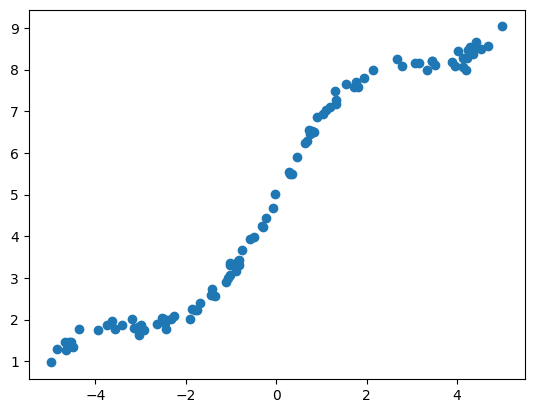

In [3]:
x = np.random.uniform(-5, 5, 100)
y = 5 + x + np.sin(x) + np.random.normal(scale=0.1, size=100)
plt.plot(x, y, "o")
x = np.expand_dims(x, axis=1)

Zaimplementuj algorytm GBT dla błędu kwadratowego. Aby to zrobić należy uzupełnić w ogólnym pseudokodzie przedstawionym na zajęciach trzy elementy:
- model początkowy $F_0(x)$ zwracający stałą wartość $v$ która optymalizuje błąd:
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) $$
- wzór na wartość ujemnego gradientu tj. pseudo-rezyduum:
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) $$
gdzie $\hat{y_i}$ to aktualna predykcja klasyfikatora tj. w $m$-tej iteracji $\hat{y_i}=F_m(x)$
- wzór na wartość liścia $v$ optymalizujący funkcję celu całego modelu GBT
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) $$
Zwróć uwagę, że suma iteruje tylko po instancjach w liściu (${N_l}$ to liczba elementów w liściu).

Wyznacz powyższe wartości (rozwiązania dla referencji znajdziesz poniżej komórek z kodem) i zaimplementuj algorytm. 

In [4]:
from helpers import Node

class GBTRegressor:
    def __init__(self, lr: float = 1.0):
        self.lr = lr
        self.initial_model = None
        self.trees = []
        self.residuals = []

    def calculate_leaf_val(x, y, last_predicted):
        residual = y - last_predicted
        return np.mean(residual)

    def fit(self, x: np.ndarray, y: np.ndarray, m: int = 1000, max_depth: int = 1):
        """
		Arguments:
		    x (np.ndarray): macierz cech o wymiarach (n, m), gdzie n to liczba przykładów, a m to liczba cech
		    y (np.ndarray): wektor klas o długości n, gdzie n to liczba przykładów
		    m (int): liczba drzew
		    max_depth (int): maksymalna głębokość pojedynczego drzewa
		
		Returns:
		    None
		
		"""
        self.trees = []
        self.residuals = []
        self.initial_model = np.mean(y)
        y_pred = np.full_like(y, self.initial_model)

        for i in range(m):
            residual = y - y_pred
            self.residuals.append(residual)

            tree = Node(calculate_leaf_value=self.calculate_leaf_val)
            tree.fit(x, residual, last_predicted=np.zeros_like(residual), max_depth=max_depth)

            update = tree.predict(x)
            y_pred += self.lr * update

            self.trees.append(tree)


    def predict(self, x: np.ndarray) -> np.ndarray:
        """
		Arguments:
		    x (np.ndarray) - macierz cech o wymiarach (n, m), gdzie n to liczba przykładów, a m to liczba cech, dla których chcemy dokonać predykcji

		Returns:
		    np.ndarray - wektor przewidzoanych klas o długości n, gdzie n to liczba przykładów
        """
        y = np.array([f.predict(x) for f in self.trees])
        return self.initial_model + self.lr * y.sum(0)

Przetestuj działanie algorytmu:

c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


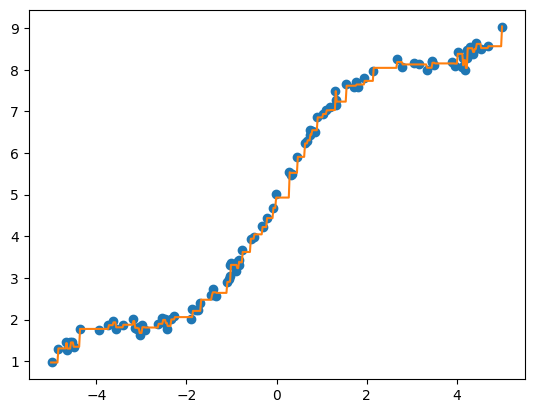

In [5]:
x_test = np.linspace(-5, 5, num=500)
x_test = np.expand_dims(x_test, axis=1)

gbt = GBTRegressor()
gbt.fit(x, y)
y_pred = gbt.predict(x_test)

plt.plot(x, y, "o")
plt.plot(x_test, y_pred, "-")

Narysuj wynik modelu z odpowednio 1, 2, 5, 10 i 100 klasyfikatorami bazowami. Za klasfikator bazowy przyjmij decision stump.

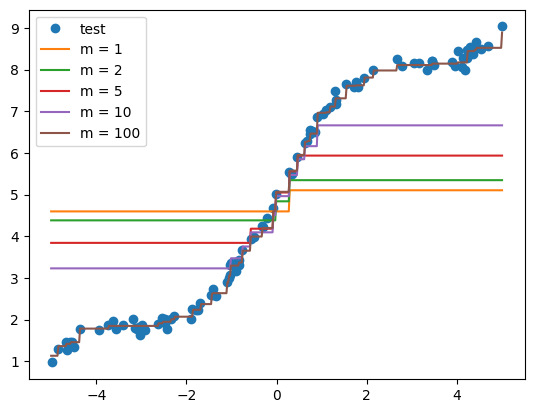

In [6]:
plt.plot(x, y, "o", label="test")

for m in [1, 2, 5, 10, 100]:
    gbt = GBTRegressor(lr=0.1)
    gbt.fit(x, y, m=m, max_depth=1)
    y_test = gbt.predict(x_test)

    plt.plot(x_test, y_test, "-", label=f"m = {m}")

plt.legend(loc="upper left")

Sprawdź jak zmieniają się wartości rezyduów w kilku początkowych iteracjach GBT. Narysuj wykresy $x$ vs $y-\hat{y}$ - zwróć uwagę, że tak właśnie wyglądają zbiory na których uczą się kolejne klasyfikatory.

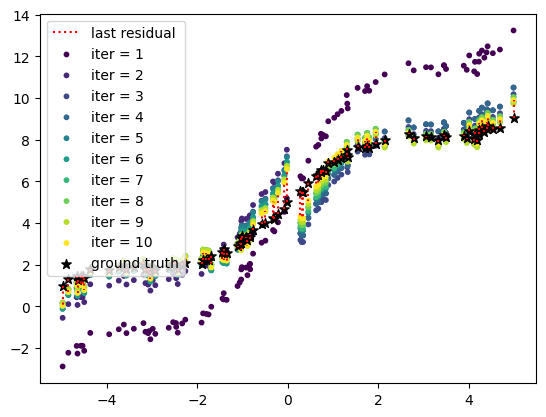

In [7]:
gbt = GBTRegressor()
m = 10
gbt.fit(x, y, m=m)
cm = plt.get_cmap("viridis")
plt.vlines(x, ymin=y, ymax=y + gbt.residuals[-1], colors="r", ls="dotted", label="last residual")
for i in range(m):
    color = cm(np.ones(len(x)) * i / (m - 1))
    plt.scatter(x, y + gbt.residuals[i], c=color, s=10, label=f"iter = {i + 1}")
plt.scatter(x, y, c="black", s=50, marker="*", label="ground truth")
plt.legend()

*Odpowiedzi:*
- model początkowy $F_0(x)$
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) = \frac{1}{2} \sum_{i=1}^N (y_i- v)^2 $$
wartość ta to oczywiście średnia arytmetyczna $v = \frac{1}{n} \sum_{i=1}^N y_i$. (Upewnij się, że to rozumiesz poprzez policzenie pochodnej i przyrównanie jej do 0).
- wzór na wartość ujemnego gradientu tj. pseudo-rezyduum 
$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) = - \frac{\partial}{\partial \hat{y_i}} \frac{1}{2}(y_i- \hat{y_i})^2$$
Co po przekształceniach wykorzystujących regułę łańcuchową ("pochodna zewnętrzna razy pochodna wewnętrzna"):
$$r_i  = -\frac{1}{2} 2(y_i- \hat{y_i})\frac{\partial}{\partial \hat{y_i}} (y_i- \hat{y_i}) 
= -(y_i- \hat{y_i})\cdot(-1)
= y_i- \hat{y_i}  $$
- wzór na wartość liścia $v$ optymalizujący funkcję celu
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) = \frac{1}{2} \sum_{i=1}^{N_l} (y_i- F_{m-1}(x_i) - v)^2 $$
Co można dalej obliczyć poprzez przyrównanie pochodnej do 0 lub poprzez zauważenie że jest to w naszej sytuacji ten sam wzór co dla modelu początkowego gdzie $y_i$ zostało zastępione $y_i- F_{m-1}(x_i)=r_i$. W związku z tym wartość liścia to $v = \frac{1}{n} \sum_{i=1}^N r_i$

## Zadanie 2.

Zaimplementuj GBT dla problemu klasyfikacji binarnej, który będzie optymalizował błąd regresji logicznej tj. entropię krzyżową wyrażoną wzorem:
$$L(y_i, \hat{p_i}) = y_i \log \hat{p_i} +  (1-y_i) \log (1-\hat{p_i}) $$
gdzie $y_i\in \{0,1\}$ to prawdziwa wartość klasy a $\hat{p_i}$ to predykcja klasyfikatora dla $i$-tego elementu.

- Zauważ, że GBT wykorzystuje drzewa regresji, które - choć modyfikujemy im sposób obliczania liści - nadal tworzą podziały dla miary SSE. Aby wykorzystać GBT do problemu klasyfikacji należy zastanowić się jak możemy wykorzystać regresor do klasyfikacji. Ten problem rozwiązywaliśmy już wcześniej przy omawianiu regresji logistycznej, gdzie tworzyliśmy klasyfikator z modelu regresji liniowej. Przypomnijmy, że w regresji logistycznej model regresji liniowej służy do predykcji logitu prawdopodobieństwa klasy (który przypomnijmy ma zakres wartości od $-\infty$ do $\infty$)
$$\text{logit}(p_x) = \ln \frac{p_x}{1-p_x}=w^Tx+b$$
Podobnie w GBT należy skonstruować model regresji do przewidywania wartości $\text{logit}(p_x)$, a jedynie przy predykcji (lub kiedy jest to wygodne) transformować go do prawdopodobieństwa klasy funkcją sigmoidalną $p_x  = \frac{1}{1+e^{- \text{logit}(p_x)}}  $

**Zadania**

1. Powyższy zapis funkcji celu $L(y_i, \hat{p_i})$ jest wyrażony w zależności od prawdopodobieństwa klasy, a nie wartości logitu $L(y_i, \text{logit}(\hat{p_i}))$. Przekształć wzór na funkcję celu, aby jej argumentem był logit. Zwróć uwagę, że model regresji będzie przewidywał właśnie logit, więc przy wyznaczaniu elementów algorytmu GBT należy liczyć np. pochodne tej właśnie przekształconej funkcji.

    Zapisz wzór na tę funkcję w komórce poniżej:


$$\hat y_i \equiv \text{logit}(\hat p_i)$$

$$\hat p_i = \frac{ 1 }{ 1 + e^{- \hat y_i} } = \frac{ e^{\hat y_i} }{ 1 + e^{\hat y_i} }$$

$$L(y_i, \hat{y}_i) = y_i \cdot \text{log}(1 + e^{- \hat y_i}) + (1-y_i) \cdot \text{log}(1 + e^{\hat y_i})$$

2. Zacznijmy uzupełniać w ogólnym pseudokodzie przedstawionym na zajęciach brakujące elementy. Wyznacz model początkowy $F_0(x)$ zwracający stałą wartość $v$ która optymalizuje błąd:
$$F_0(x) = \arg \min_v \sum_{i=1}^N L(y_i, v) $$

$$\sum_{i=1}^n \frac{\partial}{\partial v} L(y_i, v) = 0$$

$$F_0(x) = \log \left( \frac{\bar{y}}{1 - \bar{y}} \right)$$

3. Wyznacz wzór na wartość ujemnego gradientu tj. pseudo-rezyduum:

$$r_i  =  - \frac{\partial}{\partial \hat{y_i}} L(y_i, \hat{y_i}) $$
Uwaga 1: na samym końcu, aby wzór uzykał prostszą formę, możesz zamienić w nim wartości logitów z powrotem na prawdopodobieństwa. 

Uwaga 2: musiałeś policzyć go ju w poprzednim punkcie.

$$r_i = y_i - \hat{p}_i$$

4. Wzór na wartość liścia $v$ optymalizujący funkcję celu całego modelu GBT
$$v = \arg \min_v \sum_{i=1}^{N_l} L(y_i, F_{m-1}(x_i) + v) $$
niestety nie jest prosty do wyznaczenia w tym przypadku. Stosuje się przybliżenie Taylora drugiego rzedu tej funkcji i wtedy optimum ma postać:
$$v = \frac{-\sum_{i=1}^{N_L} L_i' }{\sum_{i=1}^{N_L} L_i''}$$
gdzie $L_i'$ i $L_i''$ to skrócony zapis pierwszej i drugiej pochodnej policzonej po funkcji straty dla $i$-tego elementu. Ponieważ $r_i=-L_i'$ to licznik przyjmuje postać $\sum_{i=1}^{N_L} r_i $. Wyznacz cały wzór.



$$\hat{y_i} \equiv F_{m-1}(x_i)$$

$$
v = \frac{-\sum_{i=1}^n \frac{\partial}{\partial v} L(y_i, \hat{y_i} + v)}{\sum_{i=1}^n \frac{\partial^2}{\partial^2 v} L(y_i, \hat{y_i} + v)} = \frac{-\sum_{i=1}^{N_L} r_i}{\sum_{i=1}^{N_L} \hat{p}_i (1 - \hat{p}_i)}

$$

Wykorzystując uzyskane wyniki zaimplementuj algorytm. 

In [8]:
import scipy.special

# Wskazówka: scipy.special.expit() implemenuje funkcję sigmoidalną

class GBTClassifier(object):
    def __init__(self, lr: float = 1.0):
        self.lr = lr
        self.initial_model = None
        self.trees = []
        self.residuals = []

    @staticmethod
    def calculate_leaf_val(x, grad, last_predicted):
        hess = last_predicted * (1 - last_predicted)
        return np.sum(grad) / (np.sum(hess) + 1e-10)


    def fit(self, x: np.ndarray, y: np.ndarray, m: int = 100, max_depth: int = 1):
        """
		Arguments:
		    x (np.ndarray): macierz cech o wymiarach (n, m), gdzie n to liczba przykładów, a m to liczba cech
		    y (np.ndarray): wektor klas o długości n, gdzie n to liczba przykładów
            m (int): liczba drzew
            max_depth (int): maksymalna głębokość pojedynczego drzewa
            
        Returns:
            None
		"""
        y_mean = np.mean(y)
        assert 0 < y_mean < 1
        
        self.initial_model = np.log(y_mean / (1 - y_mean))
        y_pred = np.full(x.shape[0], self.initial_model)

        for _ in range(m):
            prob = scipy.special.expit(y_pred)
            grad = y - prob

            tree = Node(calculate_leaf_value=self.calculate_leaf_val)
            tree.fit(x, grad, last_predicted=prob, max_depth=max_depth)

            update = tree.predict(x)
            y_pred += self.lr * update
            self.trees.append(tree)


    def predict(self, x: np.ndarray) -> np.ndarray:
        """
		Arguments:
		    x (np.ndarray): macierz cech o wymiarach (n, m), gdzie n to liczba przykładów, a m to liczba cech, dla których chcemy dokonać predykcji

		Returns:
		    np.ndarray: wektor przewidzoanych klas o długości n, gdzie n to liczba przykładów
        """
        y = np.array([f.predict(x) for f in self.trees])
        return scipy.special.expit(self.initial_model + self.lr * y.sum(0))

Przetestuj swoją implementację na zbinaryzowanym zbiorze `iris`.

c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\domin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


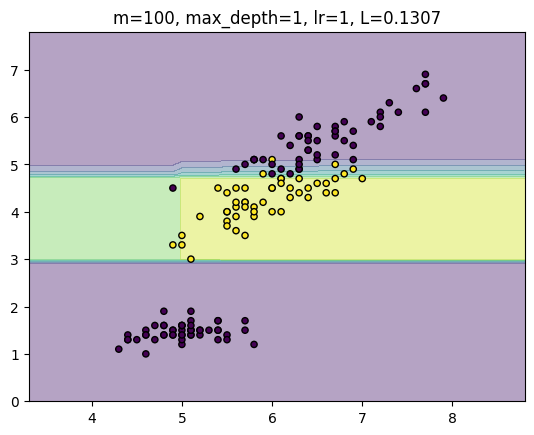

In [9]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data[:, [0, 2]]
y = iris.target
y[y == 2] = 0  # Sprowadzenie problemu do klasyfikacji binarnej


def draw_boundary(x: np.ndarray, y: np.ndarray, m: int = 100, max_depth: int = 1, lr: int = 1, ax=None):
    # Kod rysowania
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    clf = GBTClassifier(lr=lr)
    clf.fit(x, y, m=m, max_depth=max_depth)
    Y = clf.predict(x)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(x[:, 0], x[:, 1], c=y, s=20, edgecolor="k")
    loss = -np.mean(y * np.log(Y) + (1 - y) * np.log(1 - Y))
    ax.set_title(f"m={m}, max_depth={max_depth}, lr={lr}, L={loss:.4f}")


fig, ax = plt.subplots()
draw_boundary(x, y, m=100, max_depth=1, ax=ax)

Narysuj granice decyzji klasyfikatora dla 10, 20, 50 i 100 iteracji algorytmu dla klasyfikatora bazowego o maksymalnej głębokości 1 i 2.

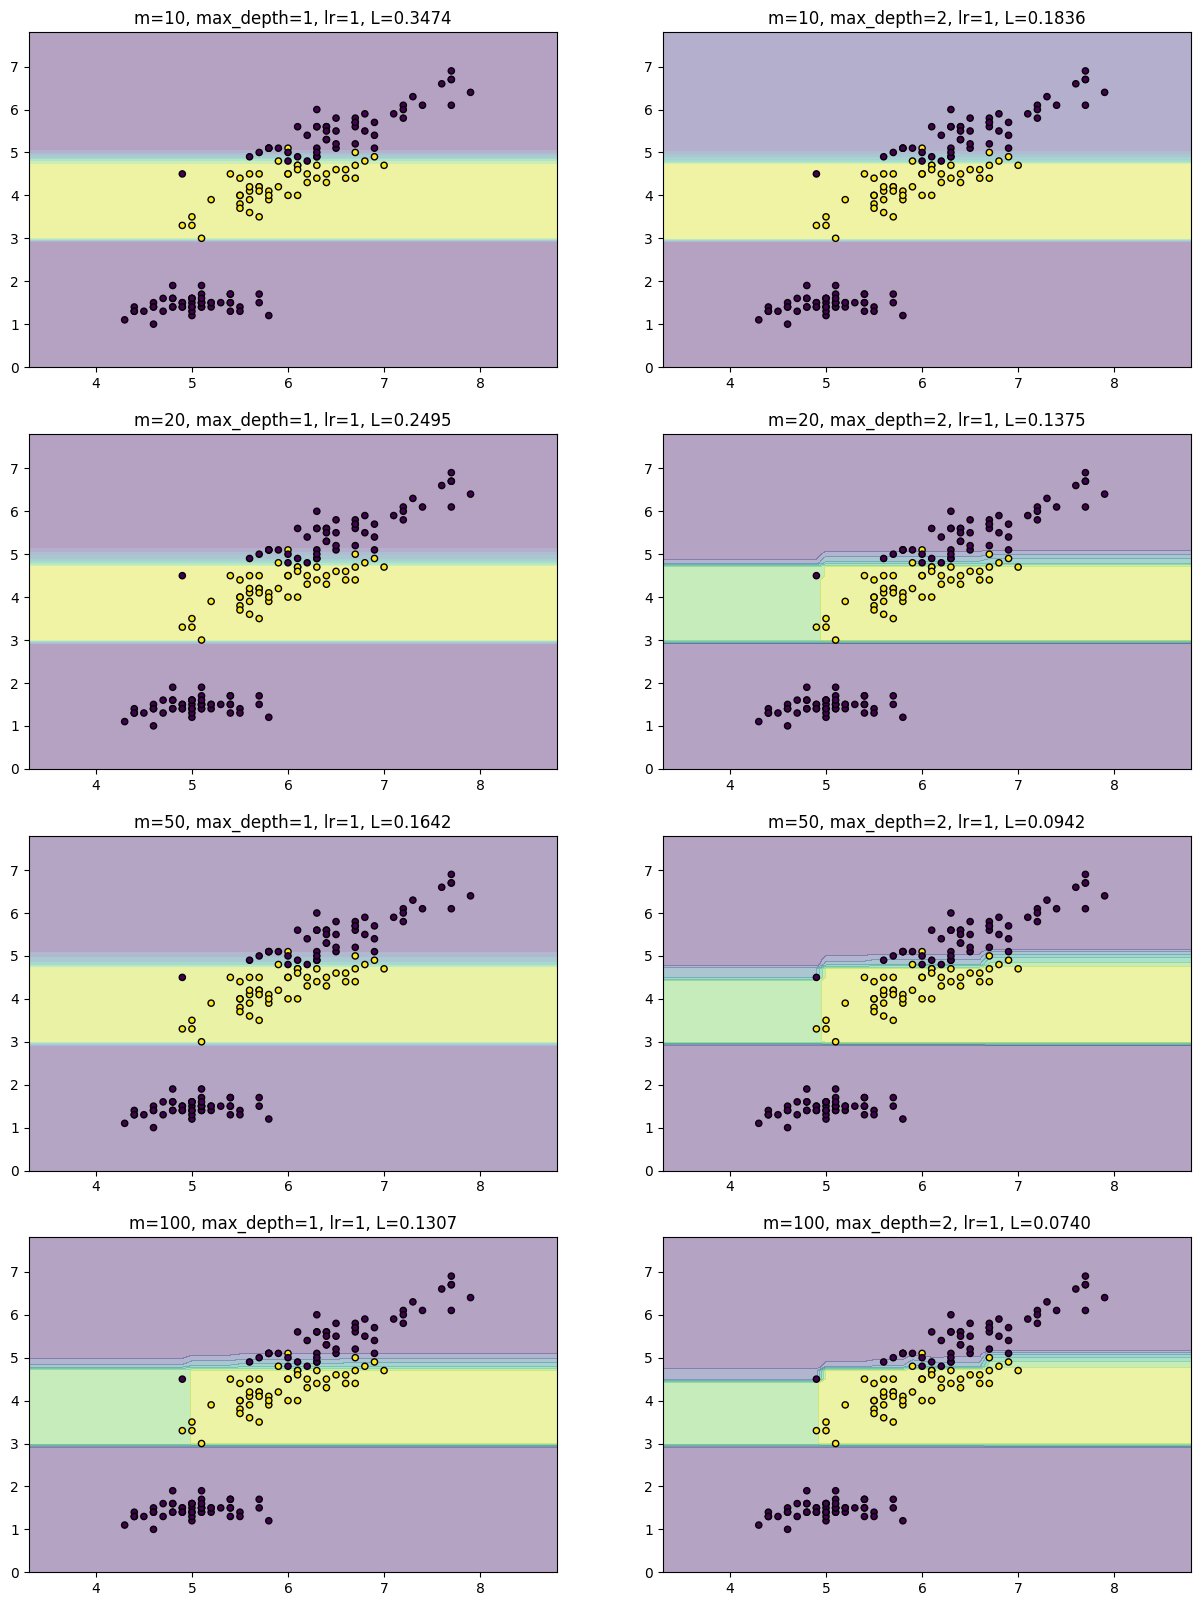

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
for i, m in enumerate([10, 20, 50, 100]):
    for j, max_depth in enumerate([1, 2]):
        draw_boundary(x, y, m=m, max_depth=max_depth, ax=axs[i][j])

**Polecenia**

1. W jaki sposób zaimplementować GBT dla problemu klasyfikacji wieloklasowej?
2. W powyższym problemie który z klasyfikatorów bazowych (o jakiej max. głębokości) poradził sobie lepiej? Czy jest sens stosować w tym problemie drzewa o głębokości większej niż testowana (tj. 2). Odpowiedź uzasadnij.
3. Dodaj do implementacji parametr $\eta$ i przetestuj kilka jego wartości. Pamętaj, że $\eta$ powinno być wykorzystywane nie tylko w funkcji `fit`, ale także `predict` - dlaczego?

Odpowiedzi na drugie pytanie kropkę umieść poniżej.

Drzewa o głębokości 2 osiągnęły lepsze wartości funkcji straty w porównaniu do drzew o mniejszej głębokości. Choć można przetestować nieco głębsze drzewa, analizując powyższą wizualizację podziałów można się spodziewać, że dalsze zwiększanie głębokości prawdopodobnie nie przyniesie już znaczącej poprawy wyników. Dodatkowo, większa głębokość drzew wydłuży czas działania modelu, wprowadzając zbędną złożoność bez realnych korzyści w kontekście jakości predykcji dla tego problemu.

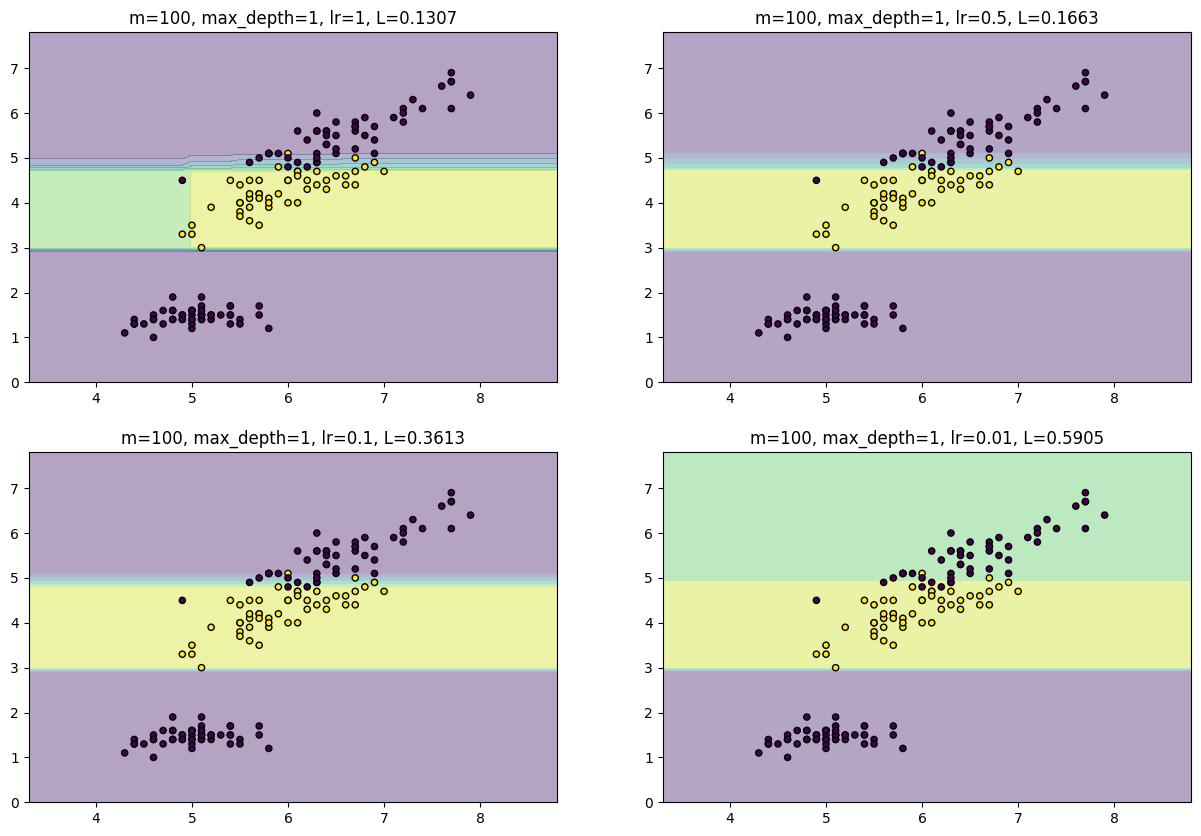

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for ax, lr in zip(axs.reshape(-1), [1, 0.5, 0.1, 0.01]):
    draw_boundary(x, y, m=100, max_depth=1, lr=lr, ax=ax)

## Zadanie 3.

GBT jest popularnym algorytmem między innymi dzięki bardzo efektywnym implementacjom potrafiącym sobie radzić z dużymi zbiorami danych. W tym ćwiczeniu Twoim zadaniem jest nauczenie się podstaw obsługi biblioteki `catboost`, którą powinieneś zainstalować.

In [12]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Wczytanie zbioru danych `iris` z poprzedniego zadania.

In [13]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data[:, [0, 2]]
y = iris.target
y[y == 2] = 0  # Sprowadzenie problemu do klasyfikacji binarnej

Trening modelu

In [14]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(logging_level="Silent")
model.fit(x, y, eval_set=(x, y), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Przykładowy kod ewaluuje działanie algorytmu na części uczącej. Podziel zbiór na część uczącą i testową i ponownie uruchom algorytm. 

In [15]:
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2)
model = CatBoostClassifier(logging_level="Silent")
model.fit(x_tr, y_tr, eval_set=(x_te, y_te), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

*Dla chętnych*: porównaj wartość funkcji straty osiągniętej przez catboost z Twoją implementacją z zadania 2.

Zaimportuj dowolny większy i bardziej wymagający zbiór danych. Ćwiczenie możesz wykonać na [dowolnym zbiorze danych](https://catboost.ai/docs/concepts/python-reference_datasets.html) - ładowanie zbioru może trochę potrwać. Jeśli masz problemy sprzętowe z operowaniem na dużym zbiorze danych to jest też dostępny zbiór `titanic`.

In [16]:
from catboost import datasets

ds_tr, ds_te = datasets.titanic()

x = ds_tr.drop(columns=["Survived"])
y = ds_tr["Survived"]

cat_features = x.select_dtypes(include='object').columns.tolist()

for col in cat_features:
    x[col] = x[col].astype(str).fillna("missing")

x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


Spróbuj osiągnąć jak najlepszy wynik na wybranym zbiorze poprzez tuning parametrów. Ważne parametry uczenia zostały opisane [tutaj](https://catboost.ai/docs/concepts/python-reference_parameters-list.html).

In [17]:
from catboost import Pool
model = CatBoostClassifier(logging_level="Silent", loss_function="Logloss")

grid = dict(
    learning_rate=[0.1, 1.0],
    depth=[4, 6, 10],
    l2_leaf_reg=[1, 3, 5, 7, 9],
    iterations=[100, 300, 500]
)

train_pool = Pool(x_tr, y_tr, cat_features=cat_features)

result = model.randomized_search(grid, train_pool, plot=True)

# `model` może być teraz użyty do predykcji 
print(result["params"])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.4514386	best: 0.4514386 (0)	total: 2.4s	remaining: 21.6s
1:	loss: 0.5050480	best: 0.4514386 (0)	total: 4.97s	remaining: 19.9s
2:	loss: 0.4856231	best: 0.4514386 (0)	total: 7.28s	remaining: 17s
3:	loss: 0.4621386	best: 0.4514386 (0)	total: 20s	remaining: 30s
4:	loss: 0.4584003	best: 0.4514386 (0)	total: 31.4s	remaining: 31.4s
5:	loss: 0.4636081	best: 0.4514386 (0)	total: 42.3s	remaining: 28.2s
6:	loss: 0.4635247	best: 0.4514386 (0)	total: 52.8s	remaining: 22.6s
7:	loss: 0.4668817	best: 0.4514386 (0)	total: 1m 9s	remaining: 17.5s
8:	loss: 0.5075954	best: 0.4514386 (0)	total: 1m 15s	remaining: 8.43s
9:	loss: 0.4590872	best: 0.4514386 (0)	total: 1m 34s	remaining: 0us
Estimating final quality...
{'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100}
